In [4]:
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import InputLayer

import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2
import numpy as np
from tqdm import tqdm
import os
from PIL import Image

Found 651 files belonging to 2 classes.


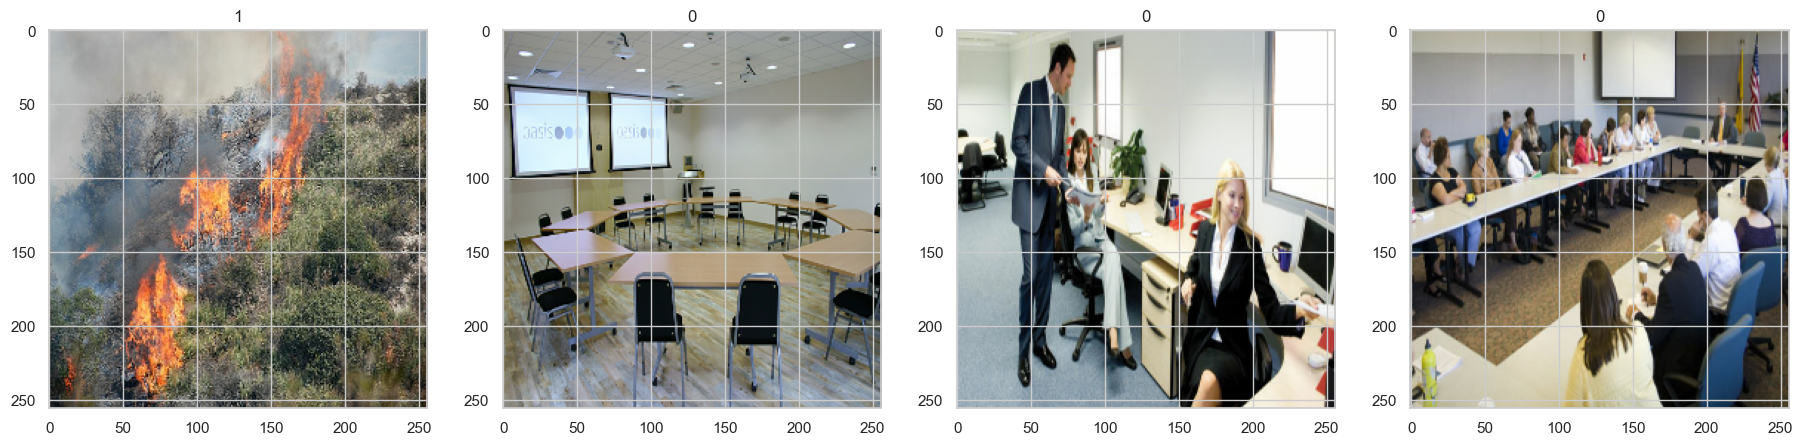

In [5]:
data = tf.keras.utils.image_dataset_from_directory('C:/Users/keshav/Downloads/archive (1)/Fire-Detection')

data_iterator = data.as_numpy_iterator()

batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

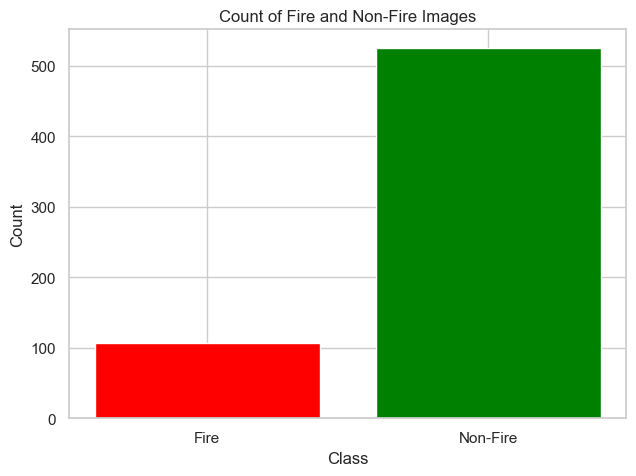

In [71]:
from pathlib import Path
fire_dataset_path = Path("C:/Users/keshav/Downloads/archive (1)/Fire-Detection")
fire_images_path = fire_dataset_path / "1"
non_fire_images_path = fire_dataset_path / "0"

fire_image_count = len(list(fire_images_path.glob("*.jpg")))
non_fire_image_count = len(list(non_fire_images_path.glob("*.jpg")))
labels = ['Fire', 'Non-Fire']
counts = [fire_image_count, non_fire_image_count]

plt.bar(labels, counts, color=['red', 'green'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Count of Fire and Non-Fire Images')
plt.show()

In [6]:

data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()

train_size = int(len(data)*.7) # training set will be 70% of data
val_size = int(len(data)*.2) # validation set size will be 20% of data
test_size = int(len(data)*.1) # test size will be 10%

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [7]:
from tensorflow.keras.models import Sequential # import sequential API. Sequential is good for 1 data input.

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout # import needed layers


model = Sequential() # create a model with sequential class

# Layers are added sequentialy
# 1st layer: convolution has 16 filters ( 3 x 3 pixels inside).
# The power is coming from activation function. Relu is replacing null values.
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
# 2nd layer - choose maximum value after the relu activation (2 x 2)
model.add(MaxPooling2D())
# 3rd layer, output is only 1 value, use 32 filters
model.add(Conv2D(32, (3,3), 1, activation='relu'))
# 4th layer
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
# flatten the data again down
model.add(Flatten())
# convolution has 2 Dense layers
model.add(Dense(256, activation='relu')) # output is 256 values
# The final sigmoid layer, close to 0 are mountains, close to 1 is the city
# Sigmoid activation is non-linear, continuously differentiable, monotonic, and has a fixed output range. Main advantage is simple and good for classifier.
# Sigmoid activation gives rise to a problem of “vanishing gradients” because Its output isn’t zero centered. Sigmoid activation is computationaly more expensive.
model.add(Dense(1, activation='sigmoid')) # single dense layer is the final layer, converts values between 0 and 1


model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [8]:
#basic cnn model
hist = model.fit(train, epochs=11, validation_data=val)



Epoch 1/11
14/14 [==============================] - 19s 292ms/step - loss: 0.4877 - accuracy: 0.7768 - val_loss: 0.2955 - val_accuracy: 0.8672
Epoch 2/11
14/14 [==============================] - 5s 282ms/step - loss: 0.3623 - accuracy: 0.8460 - val_loss: 0.2964 - val_accuracy: 0.9141
Epoch 3/11
14/14 [==============================] - 5s 281ms/step - loss: 0.3194 - accuracy: 0.8750 - val_loss: 0.2711 - val_accuracy: 0.9453
Epoch 4/11
14/14 [==============================] - 5s 297ms/step - loss: 0.2361 - accuracy: 0.8884 - val_loss: 0.2200 - val_accuracy: 0.9141
Epoch 5/11
14/14 [==============================] - 5s 284ms/step - loss: 0.2033 - accuracy: 0.9085 - val_loss: 0.1738 - val_accuracy: 0.9297
Epoch 6/11
14/14 [==============================] - 5s 295ms/step - loss: 0.1923 - accuracy: 0.9241 - val_loss: 0.1525 - val_accuracy: 0.9531
Epoch 7/11
14/14 [==============================] - 5s 286ms/step - loss: 0.1220 - accuracy: 0.9554 - val_loss: 0.1316 - val_accuracy: 0.9531
Epoch

In [25]:
model.evaluate(test)

2/2 [==============================] - 3s 111ms/step - loss: 0.0187 - accuracy: 1.0000


[0.01871321350336075, 1.0]

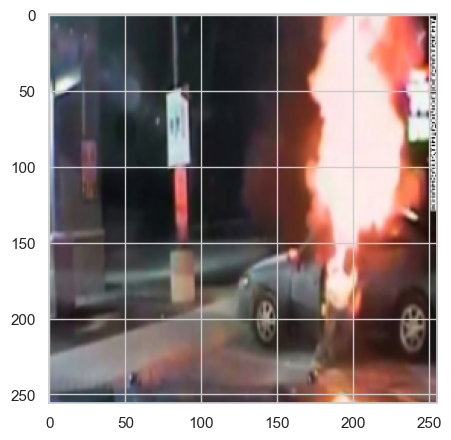

1/1 [==============================] - 0s 58ms/step
Predicted class is fire


In [12]:
# Test the model: read the image that was not used in training
img = cv2.imread('9.jpg') # bgr colors
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)) # change bgr colors to rgb
#plt.show()

img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
resize = tf.image.resize(img, (256,256)) # resize the image
plt.imshow(resize.numpy().astype(int))
plt.show()

# expand the shape of a resized image
# insert a new axis that will appear at the axis position in the expanded array shape.
np.expand_dims(resize,0)

test_prediction = model.predict(np.expand_dims(resize/255, 0))
# we devide it by 255 to scale the result
8.380818e-05

test_prediction # closer to mountains ( our scale: 0 non fire and 1 for fire)

if test_prediction > 0.5:
    print(f'Predicted class is fire')
else:
    print(f'Predicted class is non fire')


In [51]:
#resizing for resnet,inception,xception models since they are complex and smaller size will be easily computed on low end machine
import tensorflow as tf
import matplotlib.pyplot as plt

data_new = tf.keras.utils.image_dataset_from_directory(
    'C:/Users/keshav/Downloads/archive (1)/Fire-Detection',
    image_size=(128, 128),  # Resize images to 129x128
    batch_size=2  # Specify your desired batch size
)


data_new = data_new.map(lambda x,y: (x/255, y))
data_new.as_numpy_iterator().next()

train_size = int(len(data_new)*.7) # training set will be 70% of data
val_size = int(len(data_new)*.2) # validation set size will be 20% of data
test_size = int(len(data_new)*.1) # test size will be 10%

train1 = data.take(train_size)
val1 = data.skip(train_size).take(val_size)
test1 = data.skip(train_size+val_size).take(test_size)


Found 651 files belonging to 2 classes.


In [61]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input

# Load Xception model pretrained on ImageNet
xception_model = Xception(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the pretrained layers
for layer in xception_model.layers:
    layer.trainable = False

# Create your own classification layers
model = models.Sequential([
    xception_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Train the model
history = model.fit(train1, validation_data=val1, epochs=10)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test1)
print("Test Accuracy:", test_acc)


83683744/83683744 [==============================] - 26s 0us/step
Epoch 1/10
228/228 [==============================] - 6s 17ms/step - loss: 1.6496 - accuracy: 0.7763 - val_loss: 1.2738 - val_accuracy: 0.7308
Epoch 2/10
228/228 [==============================] - 3s 14ms/step - loss: 0.8600 - accuracy: 0.8289 - val_loss: 0.9843 - val_accuracy: 0.8385
Epoch 3/10
228/228 [==============================] - 3s 14ms/step - loss: 0.6190 - accuracy: 0.8509 - val_loss: 1.0007 - val_accuracy: 0.6923
Epoch 4/10
228/228 [==============================] - 3s 14ms/step - loss: 0.3214 - accuracy: 0.8991 - val_loss: 0.7720 - val_accuracy: 0.8692
Epoch 5/10
228/228 [==============================] - 3s 14ms/step - loss: 0.5359 - accuracy: 0.9079 - val_loss: 0.8040 - val_accuracy: 0.8385
Epoch 6/10
228/228 [==============================] - 3s 14ms/step - loss: 0.2365 - accuracy: 0.9474 - val_loss: 0.7109 - val_accuracy: 0.7692
Epoch 7/10
228/228 [==============================] - 3s 14ms/step - loss: 0

In [64]:
from tensorflow.keras.applications import ResNetRS50


# Load Xception model pretrained on ImageNet
resnet_model = ResNetRS50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the pretrained layers
for layer in resnet_model.layers:
    layer.trainable = False

# Create your own classification layers
model = models.Sequential([
    resnet_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Train the model
history = model.fit(train1, validation_data=val1, epochs=10)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test1)
print("Test Accuracy:", test_acc)


Epoch 1/10
228/228 [==============================] - 11s 29ms/step - loss: 0.2226 - accuracy: 0.9232 - val_loss: 0.1656 - val_accuracy: 0.9308
Epoch 2/10
228/228 [==============================] - 5s 23ms/step - loss: 0.0764 - accuracy: 0.9825 - val_loss: 0.1652 - val_accuracy: 0.9385
Epoch 3/10
228/228 [==============================] - 5s 23ms/step - loss: 0.0446 - accuracy: 0.9868 - val_loss: 0.1299 - val_accuracy: 0.9538
Epoch 4/10
228/228 [==============================] - 5s 23ms/step - loss: 0.0280 - accuracy: 0.9934 - val_loss: 0.1226 - val_accuracy: 0.9615
Epoch 5/10
228/228 [==============================] - 5s 23ms/step - loss: 0.0187 - accuracy: 1.0000 - val_loss: 0.1288 - val_accuracy: 0.9538
Epoch 6/10
228/228 [==============================] - 5s 24ms/step - loss: 0.0131 - accuracy: 1.0000 - val_loss: 0.1272 - val_accuracy: 0.9538
Epoch 7/10
228/228 [==============================] - 5s 24ms/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.1211 - val_accuracy: 0.953

In [65]:
from tensorflow.keras.applications import InceptionV3


# Load Xception model pretrained on ImageNet
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the pretrained layers
for layer in inception_model.layers:
    layer.trainable = False

# Create your own classification layers
model = models.Sequential([
    inception_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Train the model
history = model.fit(train1, validation_data=val1, epochs=10)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test1)
print("Test Accuracy:", test_acc)


87910968/87910968 [==============================] - 24s 0us/step
Epoch 1/10
228/228 [==============================] - 11s 33ms/step - loss: 10.2418 - accuracy: 0.7763 - val_loss: 5.3867 - val_accuracy: 0.7462
Epoch 2/10
228/228 [==============================] - 6s 27ms/step - loss: 5.0234 - accuracy: 0.7741 - val_loss: 9.5775 - val_accuracy: 0.7769
Epoch 3/10
228/228 [==============================] - 6s 26ms/step - loss: 5.2744 - accuracy: 0.7982 - val_loss: 20.8877 - val_accuracy: 0.7692
Epoch 4/10
228/228 [==============================] - 6s 26ms/step - loss: 3.5642 - accuracy: 0.8246 - val_loss: 5.0945 - val_accuracy: 0.8231
Epoch 5/10
228/228 [==============================] - 6s 26ms/step - loss: 1.8867 - accuracy: 0.8882 - val_loss: 8.9098 - val_accuracy: 0.8154
Epoch 6/10
228/228 [==============================] - 6s 26ms/step - loss: 4.8745 - accuracy: 0.8246 - val_loss: 6.1852 - val_accuracy: 0.8000
Epoch 7/10
228/228 [==============================] - 6s 26ms/step - loss

In [72]:
from tensorflow.keras.applications import VGG19


# Load Xception model pretrained on ImageNet
vgg = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the pretrained layers
for layer in vgg.layers:
    layer.trainable = False

# Create your own classification layers
model = models.Sequential([
    vgg,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Train the model
history = model.fit(train1, validation_data=val1, epochs=10)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test1)
print("Test Accuracy:", test_acc)


80134624/80134624 [==============================] - 22s 0us/step
Epoch 1/10
228/228 [==============================] - 5s 19ms/step - loss: 0.8248 - accuracy: 0.8377 - val_loss: 0.6197 - val_accuracy: 0.8769
Epoch 2/10
228/228 [==============================] - 4s 18ms/step - loss: 0.3378 - accuracy: 0.9298 - val_loss: 0.2615 - val_accuracy: 0.9308
Epoch 3/10
228/228 [==============================] - 4s 18ms/step - loss: 0.1584 - accuracy: 0.9627 - val_loss: 0.3083 - val_accuracy: 0.9231
Epoch 4/10
228/228 [==============================] - 4s 19ms/step - loss: 0.1083 - accuracy: 0.9737 - val_loss: 0.3285 - val_accuracy: 0.9231
Epoch 5/10
228/228 [==============================] - 4s 18ms/step - loss: 0.0720 - accuracy: 0.9803 - val_loss: 0.4272 - val_accuracy: 0.9000
Epoch 6/10
228/228 [==============================] - 4s 19ms/step - loss: 0.0548 - accuracy: 0.9890 - val_loss: 0.3482 - val_accuracy: 0.9231
Epoch 7/10
228/228 [==============================] - 4s 18ms/step - loss: 0